In [ ]:
!pip install transformers
!pip install nlp
!pip install tqdm
!pip install torch

     |████████████████████████████████| 2.1MB 5.7MB/s 
     |████████████████████████████████| 901kB 47.0MB/s 
     |████████████████████████████████| 3.3MB 48.7MB/s 
     |████████████████████████████████| 1.7MB 4.2MB/s 
     |████████████████████████████████| 245kB 53.0MB/s 


In [ ]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
device = 'cuda'
model_id = 'gpt2-large'
model = GPT2LMHeadModel.from_pretrained(model_id).to(device)
tokenizer = GPT2TokenizerFast.from_pretrained(model_id)

In [ ]:
import json
with open('SQG_eval_small.json') as f:
  data = json.load(f)

In [ ]:
max_length = model.config.n_positions
stride = 1

In [ ]:
from tqdm import tqdm
import torch

def get_ppl(seq):
    encodings = tokenizer(seq, return_tensors = 'pt')
    lls = []
    #for i in tqdm(range(0, encodings.input_ids.size(1), stride)):
    for i in range(0, encodings.input_ids.size(1), stride):
        begin_loc = max(i + stride - max_length, 0)
        end_loc = min(i + stride, encodings.input_ids.size(1))
        trg_len = end_loc - i    # may be different from stride on last loop
        input_ids = encodings.input_ids[:,begin_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:,:-trg_len] = -100

        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)
            log_likelihood = outputs[0] * trg_len

        lls.append(log_likelihood)
    ppl = torch.exp(torch.stack(lls[1:]).sum() / (end_loc-1))
    #ppl = torch.exp(torch.stack(lls).sum() / (end_loc))
    return ppl


In [ ]:
print(get_ppl('the students entered the volcano and learned about cucumbers').item())
print(get_ppl('the students entered the classroom and learned about history').item())

481.12628173828125
86.95594024658203


In [ ]:
import pandas as pd
import numpy as np
result = pd.DataFrame(np.zeros((len(data), 4)), 
                      columns = ["real", "gen_1", "gen_2", "gen_2"])

In [ ]:
for i, example in enumerate(data):
    result.loc[i,"real"] = get_ppl(example['question']).item()
    result.loc[i,"gen_1"] = get_ppl(example['gen_question'][0]).item()
    result.loc[i,"gen_2"] = get_ppl(example['gen_question'][0]).item()
    result.loc[i,"gen_3"] = get_ppl(example['gen_question'][0]).item()

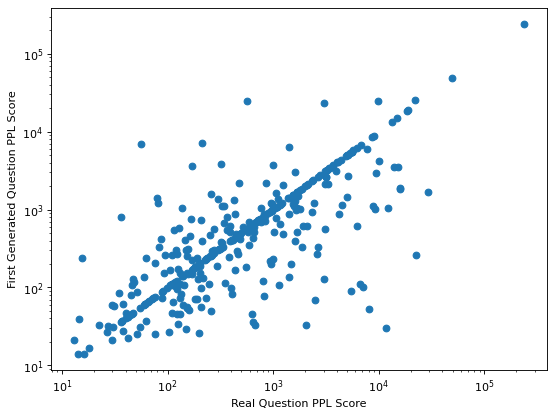

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6), dpi=80)
plt.scatter(result['real'], result['gen_1'])
plt.yscale('log')
plt.xlabel('Real Question PPL Score')
plt.ylabel('First Generated Question PPL Score')
plt.xscale('log')

In [ ]:
result

,real,gen_1,gen_2,gen_2,gen_3
0,40.567623,46.571404,46.571404,46.571404,46.571404
1,122.349640,122.349640,122.349640,122.349640,122.349640
2,769.402100,692.222839,692.222839,692.222839,692.222839
3,1988.450195,1988.450195,1988.450195,1988.450195,1988.450195
4,12283.530273,1048.785400,1048.785400,1048.785400,1048.785400
...,...,...,...,...,...
341,756.599976,756.599976,756.599976,756.599976,756.599976
342,15744.698242,1859.025513,1859.025513,1859.025513,1859.025513
343,1151.324097,1151.324097,1151.324097,1151.324097,1151.324097
344,5690.579102,5849.153809,5849.153809,5849.153809,5849.153809


In [ ]:
from scipy.stats import pearsonr
pearsonr(result['real'], result['gen_1'])

(0.9678927131799879, 2.246455052275975e-208)